In [1]:
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from pickle import load
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import wandb
from loguru import logger
from train_config import CFG
import warnings
from tfswin import SwinTransformerV2Large256, preprocess_input
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

CFG = CFG()

2023-11-15 17:10:28.856081: I tensorflow/compiler/xla/stream_executor/tpu/tpu_initializer_helper.cc:269] Libtpu path is: libtpu.so
D1115 17:10:29.002869642    8801 config.cc:112]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1115 17:10:29.002886924    8801 config.cc:112]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1115 17:10:29.002892149    8801 config.cc:112]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1115 17:10:29.002896665    8801 config.cc:112]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1115 17:10:29.002900766    8801 config.cc:112]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1115 17:10:29.002905059    8801 config.cc:112]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1115 17:10:29.002909172

In [2]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUs
    strategy = tf.distribute.get_strategy()  # default strategy that works on CPU and single GPU

REPLICAS = strategy.num_replicas_in_sync
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-11-15 17:10:37.027911: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555963811860 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2023-11-15 17:10:37.027953: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): TPU, 2a886c8
2023-11-15 17:10:37.027966: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): TPU, 2a886c8
2023-11-15 17:10:37.027977: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): TPU, 2a886c8
2023-11-15 17:10:37.027988: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): TPU, 2a886c8
2023-11-15 17:10:37.027999: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): TPU, 2a886c8
2023-11-15 17:10:37.028011: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (5): TPU, 2a886c8
2023-11-15 17:10:37.028021: I tensorflow/compiler/xla/service/service.cc:176]   StreamEx

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO

In [7]:
REPLICAS = strategy.num_replicas_in_sync

In [3]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)


def decode_image(image_data, CFG):
    image = tf.image.decode_jpeg(image_data, channels=3)  # image format uint8 [0,255]
    image = tf.cast(image, tf.uint8)
    image = tf.image.resize_with_crop_or_pad(image, CFG.RAW_SIZE, CFG.RAW_SIZE)
    image = tf.image.random_crop(image, size=[*CFG.IMAGE_SIZE, 3])  #, method="lanczos5")
    
    return image


def read_labeled_tfrecord(example, CFG):
    feature_description = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/id": tf.io.FixedLenFeature([], tf.string),
        "image/meta/dataset": tf.io.FixedLenFeature([], tf.int64),
        "image/meta/longitude": tf.io.FixedLenFeature([], tf.float32),
        "image/meta/latitude": tf.io.FixedLenFeature([], tf.float32),
        "image/meta/date": tf.io.FixedLenFeature([], tf.string),
        "image/meta/class_priors": tf.io.FixedLenFeature([], tf.float32),
        "image/class/label": tf.io.FixedLenFeature([], tf.int64),
        "image/class/text": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example["image/encoded"], CFG)
    label = tf.cast(example["image/class/label"], tf.int32)
    return image, label


def load_dataset(filenames, CFG):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(lambda x: read_labeled_tfrecord(x, CFG), num_parallel_calls=AUTO)
    return dataset

def get_model(res: int = 256, num_classes: int = 467) -> tf.keras.Model:
    inputs = layers.Input(shape=(*res, 3), dtype='int8')
    outputs = SwinTransformerV2Large256(include_top=False, pooling='avg', input_shape=[*res, 3])(inputs)
    outputs = layers.Dense(num_classes, activation='softmax')(outputs)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model


def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transform matrix which transforms indices

    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.0
    shear = math.pi * shear / 180.0

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst], axis=0), [3, 3])

    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')

    rotation_matrix = get_3x3_mat([c1, s1, zero, -s1, c1, zero, zero, zero, one])
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one, s2, zero, zero, c2, zero, zero, zero, one])
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one])
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one, zero, height_shift, zero, one, width_shift, zero, zero, one])

    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def data_augment(img, label, CFG):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    # img = tf.image.stateless_random_crop(img, [CFG.MODEL_SIZE, CFG.MODEL_SIZE, 3])
    img = transform(img, CFG)
    img = tf.image.random_flip_left_right(img)
    # img = image.random_hue(img, 0.01)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_brightness(img, 0.1)
    return img, label


def transform(image, CFG):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = CFG.IMAGE_SIZE[0]
    XDIM = DIM % 2  # fix for size 331

    rot = 15. * tf.random.normal([1], dtype='float32')
    shr = 5. * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 10.
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 10.
    h_shift = 16. * tf.random.normal([1], dtype='float32')
    w_shift = 16. * tf.random.normal([1], dtype='float32')

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift)

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM // 2, -DIM // 2, -1), DIM)
    y = tf.tile(tf.range(-DIM // 2, DIM // 2), [DIM])
    z = tf.ones([DIM * DIM], dtype='int32')
    idx = tf.stack([x, y, z])

    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM // 2 + XDIM + 1, DIM // 2)

    # FIND ORIGIN PIXEL VALUES
    idx3 = tf.stack([DIM // 2 - idx2[0,], DIM // 2 - 1 + idx2[1,]])
    d = tf.gather_nd(image, tf.transpose(idx3))

    return tf.reshape(d, [DIM, DIM, 3])


def get_batched_dataset(filenames, CFG, train=False):
    dataset = load_dataset(filenames, CFG)
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTO)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        if CFG.AUGMENT:
            dataset = dataset.map(lambda x, y: data_augment(x, y, CFG), num_parallel_calls=AUTO)
        # dataset = dataset.shuffle(BATCH_SIZE * 10)
        dataset = dataset.repeat()
    dataset = dataset.batch(CFG.BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)

    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break

    return numpy_images, numpy_labels

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = class_dict[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [4]:
CFG.BATCH_SIZE =  REPLICAS * CFG.BASE_BATCH_SIZE

class_dict = load(open("class_dict.pkl", "rb"))

AUTO = tf.data.AUTOTUNE

GCS_PATH_SELECT = {
    192: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-192x192",
    224: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-224x224v2",
    256: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-256x256",
    384: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-384x384",
    512: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-512x512",
    None: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-raw",
}
GCS_PATH = GCS_PATH_SELECT[None]

filenames = tf.io.gfile.glob(f"{GCS_PATH}/train*.tfrec")
filenames, test_filenames = train_test_split(filenames, test_size=1)
training_filenames, validation_filenames = train_test_split(filenames, test_size=0.2, shuffle=True)
# validation_filenames = tf.io.gfile.glob(f"{GCS_PATH}/val*.tfrec")

num_train = count_data_items(training_filenames)
num_val = count_data_items(validation_filenames)

2023-11-15 17:10:55.386098: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


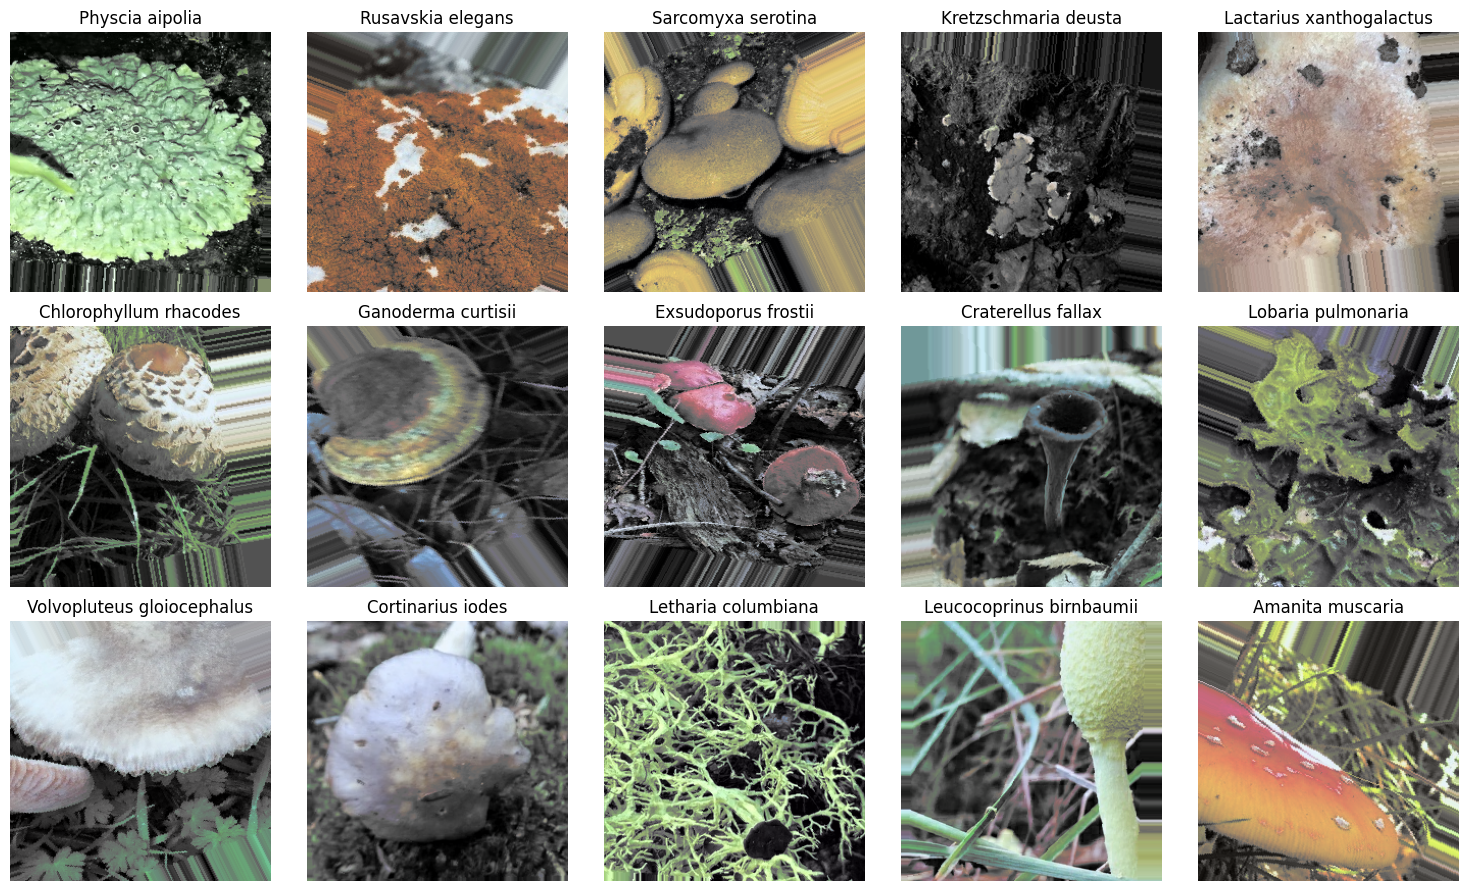

In [5]:
sample_images, sample_labels = next(iter(get_batched_dataset(training_filenames, CFG, train=True)))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n]).numpy()
    # image = image[:, :, ::-1]
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(class_dict[sample_labels.numpy()[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
CFG.TOTAL_STEPS = int((num_train / CFG.BATCH_SIZE) * CFG.EPOCHS - 1)
validation_steps = num_val // CFG.BATCH_SIZE
steps_per_epoch = num_train // CFG.BATCH_SIZE

CFG.WARMUP_STEPS = steps_per_epoch * 2
CFG.DECAY_STEPS = steps_per_epoch * CFG.EPOCHS - CFG.WARMUP_STEPS

In [7]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)
    lr_rate = keras.optimizers.schedules.CosineDecay(CFG.LR_START, warmup_steps=CFG.WARMUP_STEPS, decay_steps=CFG.DECAY_STEPS, alpha=CFG.ALPHA, warmup_target=CFG.WARMUP_TARGET)
    optimizer = keras.optimizers.AdamW(lr_rate)
    loss = keras.losses.SparseCategoricalCrossentropy()
    model = get_model(res=CFG.IMAGE_SIZE, num_classes=len(class_dict))
    model.compile(loss=loss, optimizer=optimizer, metrics=[
        "accuracy",
        keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy")
        ])

2023-11-15 17:11:19.441022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-15 17:11:21.079959: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
config=wandb.helper.parse_config(
    CFG, 
    include=(
        'ALPHA', 'AUGMENT', 'BATCH_SIZE', 'EPOCHS', 'ES_PATIENCE', 'IMAGE_SIZE', 'DECAY_STEPS',
        'LR_START', 'MODEL_SIZE', 'SEED', 'TTA', 'TOTAL_STEPS', 'WARMUP_STEPS', 'WARMUP_TARGET',
        'RAW_SIZE',
    )
)
wandb.init(
    project="Mushroom-Classifier",
    tags=[CFG.MODEL, 'AdamW', CFG.LR_SCHED, str(CFG.IMAGE_SIZE[0])],
    config=config,
    dir="../",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: g-broughton. Use `wandb login --relogin` to force relogin


In [9]:
CFG.CKPT_DIR.mkdir(parents=True, exist_ok=True)
callbacks = [
    wandb.keras.WandbMetricsLogger(log_freq="batch"),
    wandb.keras.WandbModelCheckpoint(
        str(CFG.CKPT_DIR),  # .h5 for weights, dir for whole model
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        # options=options,
        initial_value_threshold=2.0,

    ),    
]

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [10]:
tr_ds = get_batched_dataset(training_filenames, CFG, train=True)
val_ds = get_batched_dataset(validation_filenames, CFG)

history = model.fit(
    tr_ds, 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    epochs=CFG.EPOCHS, 
    callbacks=callbacks
    )

Epoch 1/30


2023-11-15 17:14:42.670259: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:5922396560065021363
2023-11-15 17:14:53.671306: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-15 17:14:58.294923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-15 17:15:06.960083: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(1392968933846301149:0:0), session_name()
2023-11-15 17:17:04.479551: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 1392968933846301149:0:0 with session name  took 1m57.519330488s and succeeded
2023-11-15 17:17:04.790867: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host

315/315 [==============================] - ETA: 0s - loss: 2.9758 - accuracy: 0.3700 - top-3-accuracy: 0.5449

2023-11-15 17:23:32.391158: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:3147987398945661230
2023-11-15 17:23:35.081362: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-15 17:23:36.393427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-15 17:23:38.764398: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(13184445192755667303:0:0), session_name()
2023-11-15 17:24:07.268046: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 13184445192755667303:0:0 with session name  took 28.503575852s and succeeded
2023-11-15 17:24:07.347131: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host compilation


Epoch 1: val_loss improved from 2.00000 to 1.55767, saving model to /home/broug/models/swinv2_large_256/1115-1710
INFO:tensorflow:Assets written to: /home/broug/models/swinv2_large_256/1115-1710/assets


INFO:tensorflow:Assets written to: /home/broug/models/swinv2_large_256/1115-1710/assets
wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 30.2s


315/315 [==============================] - 978s 2s/step - loss: 2.9758 - accuracy: 0.3700 - top-3-accuracy: 0.5449 - val_loss: 1.5577 - val_accuracy: 0.5909 - val_top-3-accuracy: 0.7972
Epoch 2/30
315/315 [==============================] - ETA: 0s - loss: 1.9954 - accuracy: 0.5053 - top-3-accuracy: 0.7160
Epoch 2: val_loss did not improve from 1.55767


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.6s


315/315 [==============================] - 429s 1s/step - loss: 1.9954 - accuracy: 0.5053 - top-3-accuracy: 0.7160 - val_loss: 1.8581 - val_accuracy: 0.5266 - val_top-3-accuracy: 0.7416
Epoch 3/30
315/315 [==============================] - ETA: 0s - loss: 1.8901 - accuracy: 0.5238 - top-3-accuracy: 0.7338
Epoch 3: val_loss did not improve from 1.55767


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.2s


315/315 [==============================] - 431s 1s/step - loss: 1.8901 - accuracy: 0.5238 - top-3-accuracy: 0.7338 - val_loss: 1.6987 - val_accuracy: 0.5714 - val_top-3-accuracy: 0.7782
Epoch 4/30
315/315 [==============================] - ETA: 0s - loss: 1.6608 - accuracy: 0.5681 - top-3-accuracy: 0.7750
Epoch 4: val_loss did not improve from 1.55767


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 431s 1s/step - loss: 1.6608 - accuracy: 0.5681 - top-3-accuracy: 0.7750 - val_loss: 1.5832 - val_accuracy: 0.5928 - val_top-3-accuracy: 0.7977
Epoch 5/30
315/315 [==============================] - ETA: 0s - loss: 1.5203 - accuracy: 0.5973 - top-3-accuracy: 0.7976
Epoch 5: val_loss improved from 1.55767 to 1.50323, saving model to /home/broug/models/swinv2_large_256/1115-1710
INFO:tensorflow:Assets written to: /home/broug/models/swinv2_large_256/1115-1710/assets


INFO:tensorflow:Assets written to: /home/broug/models/swinv2_large_256/1115-1710/assets
wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.3s


315/315 [==============================] - 664s 2s/step - loss: 1.5203 - accuracy: 0.5973 - top-3-accuracy: 0.7976 - val_loss: 1.5032 - val_accuracy: 0.6117 - val_top-3-accuracy: 0.8110
Epoch 6/30
315/315 [==============================] - ETA: 0s - loss: 1.3911 - accuracy: 0.6240 - top-3-accuracy: 0.8231
Epoch 6: val_loss did not improve from 1.50323


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.0s


315/315 [==============================] - 429s 1s/step - loss: 1.3911 - accuracy: 0.6240 - top-3-accuracy: 0.8231 - val_loss: 1.5489 - val_accuracy: 0.6116 - val_top-3-accuracy: 0.8054
Epoch 7/30
315/315 [==============================] - ETA: 0s - loss: 1.2828 - accuracy: 0.6486 - top-3-accuracy: 0.8409
Epoch 7: val_loss improved from 1.50323 to 1.47931, saving model to /home/broug/models/swinv2_large_256/1115-1710
INFO:tensorflow:Assets written to: /home/broug/models/swinv2_large_256/1115-1710/assets


INFO:tensorflow:Assets written to: /home/broug/models/swinv2_large_256/1115-1710/assets
wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 665s 2s/step - loss: 1.2828 - accuracy: 0.6486 - top-3-accuracy: 0.8409 - val_loss: 1.4793 - val_accuracy: 0.6249 - val_top-3-accuracy: 0.8175
Epoch 8/30
315/315 [==============================] - ETA: 0s - loss: 1.1761 - accuracy: 0.6719 - top-3-accuracy: 0.8588
Epoch 8: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 430s 1s/step - loss: 1.1761 - accuracy: 0.6719 - top-3-accuracy: 0.8588 - val_loss: 1.5742 - val_accuracy: 0.6139 - val_top-3-accuracy: 0.8093
Epoch 9/30
315/315 [==============================] - ETA: 0s - loss: 1.0808 - accuracy: 0.6947 - top-3-accuracy: 0.8760
Epoch 9: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 25.9s


315/315 [==============================] - 429s 1s/step - loss: 1.0808 - accuracy: 0.6947 - top-3-accuracy: 0.8760 - val_loss: 1.5166 - val_accuracy: 0.6248 - val_top-3-accuracy: 0.8157
Epoch 10/30
315/315 [==============================] - ETA: 0s - loss: 0.9609 - accuracy: 0.7220 - top-3-accuracy: 0.8945
Epoch 10: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 430s 1s/step - loss: 0.9609 - accuracy: 0.7220 - top-3-accuracy: 0.8945 - val_loss: 1.5417 - val_accuracy: 0.6262 - val_top-3-accuracy: 0.8176
Epoch 11/30
315/315 [==============================] - ETA: 0s - loss: 0.8818 - accuracy: 0.7438 - top-3-accuracy: 0.9074
Epoch 11: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 25.9s


315/315 [==============================] - 429s 1s/step - loss: 0.8818 - accuracy: 0.7438 - top-3-accuracy: 0.9074 - val_loss: 1.5343 - val_accuracy: 0.6294 - val_top-3-accuracy: 0.8192
Epoch 12/30
315/315 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.7668 - top-3-accuracy: 0.9225
Epoch 12: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.4s


315/315 [==============================] - 429s 1s/step - loss: 0.7865 - accuracy: 0.7668 - top-3-accuracy: 0.9225 - val_loss: 1.5606 - val_accuracy: 0.6336 - val_top-3-accuracy: 0.8200
Epoch 13/30
315/315 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.7954 - top-3-accuracy: 0.9366
Epoch 13: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.4s


315/315 [==============================] - 429s 1s/step - loss: 0.6872 - accuracy: 0.7954 - top-3-accuracy: 0.9366 - val_loss: 1.6553 - val_accuracy: 0.6287 - val_top-3-accuracy: 0.8190
Epoch 14/30
315/315 [==============================] - ETA: 0s - loss: 0.6068 - accuracy: 0.8151 - top-3-accuracy: 0.9480
Epoch 14: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.2s


315/315 [==============================] - 428s 1s/step - loss: 0.6068 - accuracy: 0.8151 - top-3-accuracy: 0.9480 - val_loss: 1.6699 - val_accuracy: 0.6383 - val_top-3-accuracy: 0.8212
Epoch 15/30
315/315 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8410 - top-3-accuracy: 0.9602
Epoch 15: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.4s


315/315 [==============================] - 429s 1s/step - loss: 0.5136 - accuracy: 0.8410 - top-3-accuracy: 0.9602 - val_loss: 1.6646 - val_accuracy: 0.6541 - val_top-3-accuracy: 0.8319
Epoch 16/30
315/315 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8683 - top-3-accuracy: 0.9702
Epoch 16: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.3s


315/315 [==============================] - 431s 1s/step - loss: 0.4252 - accuracy: 0.8683 - top-3-accuracy: 0.9702 - val_loss: 1.6911 - val_accuracy: 0.6550 - val_top-3-accuracy: 0.8340
Epoch 17/30
315/315 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.8883 - top-3-accuracy: 0.9778
Epoch 17: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 428s 1s/step - loss: 0.3535 - accuracy: 0.8883 - top-3-accuracy: 0.9778 - val_loss: 1.8098 - val_accuracy: 0.6571 - val_top-3-accuracy: 0.8344
Epoch 18/30
315/315 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.9095 - top-3-accuracy: 0.9836
Epoch 18: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.2s


315/315 [==============================] - 429s 1s/step - loss: 0.2850 - accuracy: 0.9095 - top-3-accuracy: 0.9836 - val_loss: 1.8008 - val_accuracy: 0.6641 - val_top-3-accuracy: 0.8408
Epoch 19/30
315/315 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9279 - top-3-accuracy: 0.9885
Epoch 19: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 429s 1s/step - loss: 0.2250 - accuracy: 0.9279 - top-3-accuracy: 0.9885 - val_loss: 1.7832 - val_accuracy: 0.6777 - val_top-3-accuracy: 0.8501
Epoch 20/30
315/315 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9419 - top-3-accuracy: 0.9918
Epoch 20: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 429s 1s/step - loss: 0.1817 - accuracy: 0.9419 - top-3-accuracy: 0.9918 - val_loss: 1.7823 - val_accuracy: 0.6795 - val_top-3-accuracy: 0.8491
Epoch 21/30
315/315 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9563 - top-3-accuracy: 0.9943
Epoch 21: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.0s


315/315 [==============================] - 430s 1s/step - loss: 0.1377 - accuracy: 0.9563 - top-3-accuracy: 0.9943 - val_loss: 1.8386 - val_accuracy: 0.6897 - val_top-3-accuracy: 0.8577
Epoch 22/30
315/315 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9647 - top-3-accuracy: 0.9957
Epoch 22: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.0s


315/315 [==============================] - 430s 1s/step - loss: 0.1105 - accuracy: 0.9647 - top-3-accuracy: 0.9957 - val_loss: 1.8572 - val_accuracy: 0.6966 - val_top-3-accuracy: 0.8608
Epoch 23/30
315/315 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9724 - top-3-accuracy: 0.9968
Epoch 23: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.0s


315/315 [==============================] - 428s 1s/step - loss: 0.0861 - accuracy: 0.9724 - top-3-accuracy: 0.9968 - val_loss: 1.9080 - val_accuracy: 0.6951 - val_top-3-accuracy: 0.8568
Epoch 24/30
315/315 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9780 - top-3-accuracy: 0.9973
Epoch 24: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 429s 1s/step - loss: 0.0709 - accuracy: 0.9780 - top-3-accuracy: 0.9973 - val_loss: 1.8601 - val_accuracy: 0.7049 - val_top-3-accuracy: 0.8647
Epoch 25/30
315/315 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9844 - top-3-accuracy: 0.9983
Epoch 25: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 430s 1s/step - loss: 0.0511 - accuracy: 0.9844 - top-3-accuracy: 0.9983 - val_loss: 1.9017 - val_accuracy: 0.7080 - val_top-3-accuracy: 0.8681
Epoch 26/30
315/315 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9877 - top-3-accuracy: 0.9989
Epoch 26: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.2s


315/315 [==============================] - 430s 1s/step - loss: 0.0394 - accuracy: 0.9877 - top-3-accuracy: 0.9989 - val_loss: 1.9698 - val_accuracy: 0.7097 - val_top-3-accuracy: 0.8685
Epoch 27/30
315/315 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9890 - top-3-accuracy: 0.9989
Epoch 27: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.0s


315/315 [==============================] - 430s 1s/step - loss: 0.0357 - accuracy: 0.9890 - top-3-accuracy: 0.9989 - val_loss: 1.9693 - val_accuracy: 0.7103 - val_top-3-accuracy: 0.8688
Epoch 28/30
315/315 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9897 - top-3-accuracy: 0.9989
Epoch 28: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 26.1s


315/315 [==============================] - 430s 1s/step - loss: 0.0337 - accuracy: 0.9897 - top-3-accuracy: 0.9989 - val_loss: 1.9597 - val_accuracy: 0.7106 - val_top-3-accuracy: 0.8689
Epoch 29/30
315/315 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9911 - top-3-accuracy: 0.9991
Epoch 29: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 25.9s


315/315 [==============================] - 428s 1s/step - loss: 0.0290 - accuracy: 0.9911 - top-3-accuracy: 0.9991 - val_loss: 1.9550 - val_accuracy: 0.7132 - val_top-3-accuracy: 0.8709
Epoch 30/30
315/315 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9919 - top-3-accuracy: 0.9990
Epoch 30: val_loss did not improve from 1.47931


wandb: Adding directory to artifact (/home/broug/models/swinv2_large_256/1115-1710)... Done. 25.9s


315/315 [==============================] - 429s 1s/step - loss: 0.0281 - accuracy: 0.9919 - top-3-accuracy: 0.9990 - val_loss: 1.9536 - val_accuracy: 0.7135 - val_top-3-accuracy: 0.8716


In [11]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch/accuracy,▁▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▂▄▇██████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
batch/loss,█▆▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/top-3-accuracy,▁▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████
epoch/accuracy,▁▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▅█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-3-accuracy,▁▄▄▅▅▅▆▆▆▆▇▇▇▇▇███████████████
epoch/val_accuracy,▃▁▃▃▄▄▅▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███████
